In [1]:
import sys
sys.path.append('../src')

from module.module import Linear, Conv1D, MaxPool1D, Flatten
from module.activation import TanH, Sigmoide, ReLU

from loss.loss import CrossEntropie, CELogSoftmax
from networks.optim import Optim
from networks.sequentiel import Sequentiel

from utils.processing import one_hot_y, normalisation
from utils.plots import plot_net, classification_report

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dt = pd.read_csv("../data/fashion-mnist_train.csv")

X = dt.drop(["label"], axis=1).values
X = (X - X.min(axis=1, keepdims=True)) / (X.max(axis=1, keepdims=True) - X.min(axis=1, keepdims=True))

y = dt["label"].values

indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]

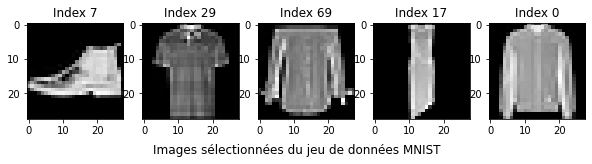

In [4]:
indices = [7, 29, 69, 17, 0]

fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(10, 5))

for i, ax in zip(indices, axes):
    ax.imshow(X[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Index {i}")
    
fig.suptitle("Images sélectionnées du jeu de données MNIST", y=0.3)
plt.show()

In [5]:
X, _, y, _ = train_test_split(X, y, stratify=y, test_size=0.8)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [6]:
classes = len(np.unique(y))

input_neurons = X_train.shape[1]
output_neurons = classes

In [7]:
y_one_hot = one_hot_y(y_train, classes)

In [8]:
y_one_hot.shape

(9000, 10)

In [9]:
X_conv = X_train[:,:,np.newaxis]
X_conv.shape

(9000, 784, 1)

100%|██████████| 100/100 [1:51:59<00:00, 67.20s/it]

Training completed.


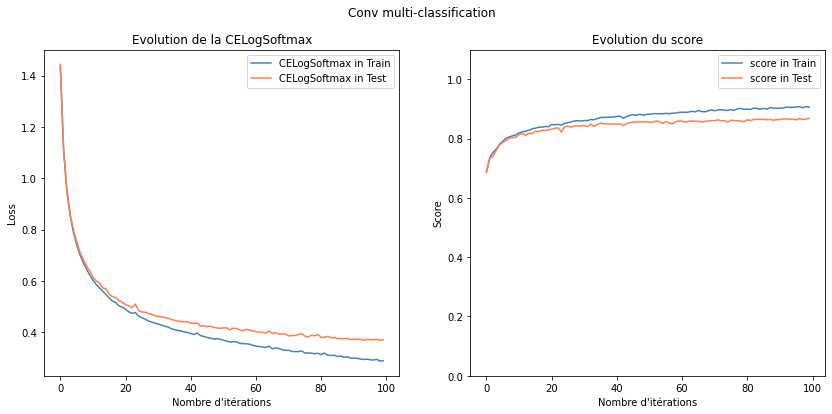

In [10]:
net = Sequentiel([
    Conv1D(k_size=3, chan_in=1, chan_out=32, stride=2, init="xavier"),
    MaxPool1D(2, 2), 
    Flatten(),
    Linear(6240, 3000, init="xavier"),
    ReLU(),
    Linear(3000, 500, init="xavier"),
    ReLU(),
    Linear(500, 100, init="xavier"),
    ReLU(),
    Linear(100, 10, init="xavier"),
], classes_type="multi")

optim = Optim(net, CELogSoftmax(), eps=1e-5)
optim.SGD(X_conv, y_one_hot, test_train_split=True, batch_size=50, epochs=100, verbose=False)

plot_net(optim, X_conv, y_one_hot, net_type="multiclass", net_title="Conv multi-classification")

In [11]:
net.score(X_test[:,:,np.newaxis], y_test)

0.8526666666666667

In [12]:
yhat = net.predict(X_test[:,:,np.newaxis])

In [13]:
yhat = yhat.reshape(-1)

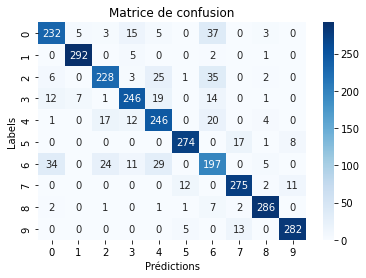

In [14]:
df = classification_report(y_test, yhat, [f"{i}" for i in range(classes)])

In [15]:
print(df.to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrllr}
\toprule
{} &  precision & recall & f1-score &  support \\
class    &            &        &          &          \\
\midrule
0        &       0.81 &   0.77 &     0.79 &      300 \\
1        &       0.96 &   0.97 &     0.97 &      300 \\
2        &       0.83 &   0.76 &     0.79 &      300 \\
3        &       0.84 &   0.82 &     0.83 &      300 \\
4        &       0.76 &   0.82 &     0.79 &      300 \\
5        &       0.94 &   0.91 &     0.92 &      300 \\
6        &       0.63 &   0.66 &     0.64 &      300 \\
7        &       0.90 &   0.92 &     0.91 &      300 \\
8        &       0.94 &   0.95 &     0.95 &      300 \\
9        &       0.94 &   0.94 &     0.94 &      300 \\
accuracy &       0.85 &        &          &     3000 \\
\bottomrule
\end{tabular}



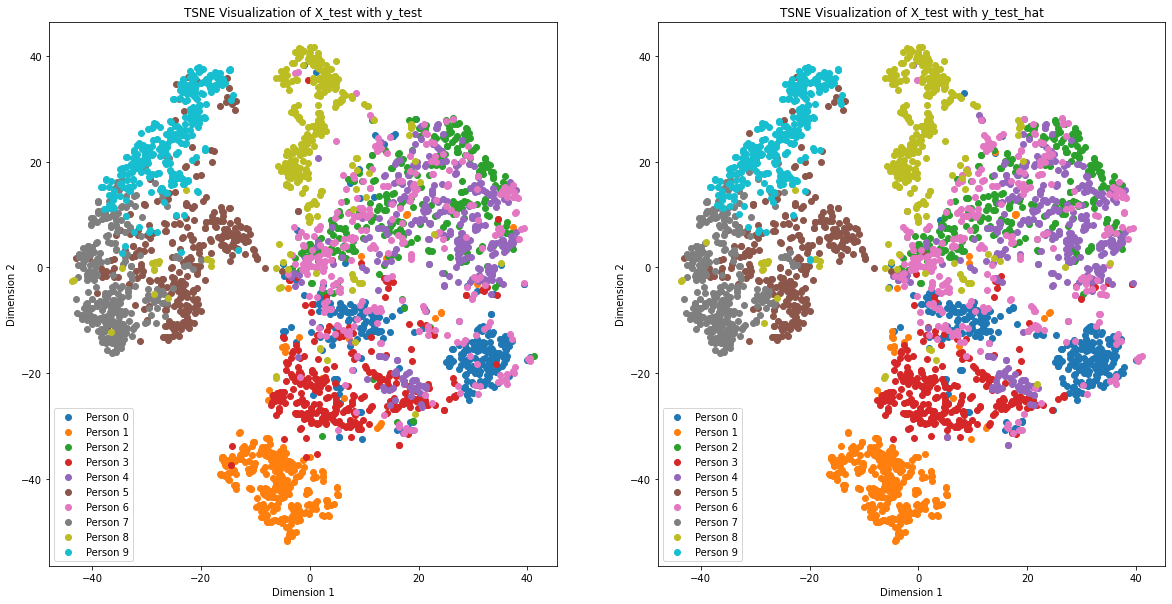

In [16]:
aff = TSNE(n_components=2, random_state=0, init="pca", n_iter=500, verbose=0)
sign_aff = aff.fit_transform(X_test)

colors = {i: plt.cm.tab10(i) for i in range(classes)}

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].set_title("TSNE Visualization of X_test with y_test")

for cl in range(classes):
    axs[0].scatter(sign_aff[y_test == cl][:, 0], sign_aff[y_test == cl][:, 1], color=colors[cl], label=f"Person {cl}")
    
axs[0].set_xlabel("Dimension 1")
axs[0].set_ylabel("Dimension 2")
axs[0].legend()

y_test_hat = net.predict(X_test[:,:,np.newaxis]).reshape(-1)

axs[1].set_title("TSNE Visualization of X_test with y_test_hat")
for cl in range(classes):
    axs[1].scatter(sign_aff[y_test_hat == cl][:, 0], sign_aff[y_test_hat == cl][:, 1], color=colors[cl], label=f"Person {cl}")
    
axs[1].set_xlabel("Dimension 1")
axs[1].set_ylabel("Dimension 2")
axs[1].legend()

plt.show()